<a href="https://colab.research.google.com/github/mrm8488/shared_colab_notebooks/blob/master/T5_wikiSQL_with_HF_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial to fine-tune Google's text2text/seq2seq T5 model on WikiSQL dataset to translate from SQL to Natural Language and vice versa (multitask).

Author: **Manuel Romero** [mrm8488](https://twitter.com/mrm8488). NLP/NLG Senior Engineer at [Narrativa](https://narrativa.com/) and Head collaborator at [HuggingFace](https://huggingface.co/mrm8488)

> Note: This is still WIP so you may find errors

## PART 1
## Fine-tune T5 (small) to translate form Natural Language to SQL

## The model
## [Exploring Transfer Learning with **T5**: the Text-To-Text Transfer Transformer](https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html)

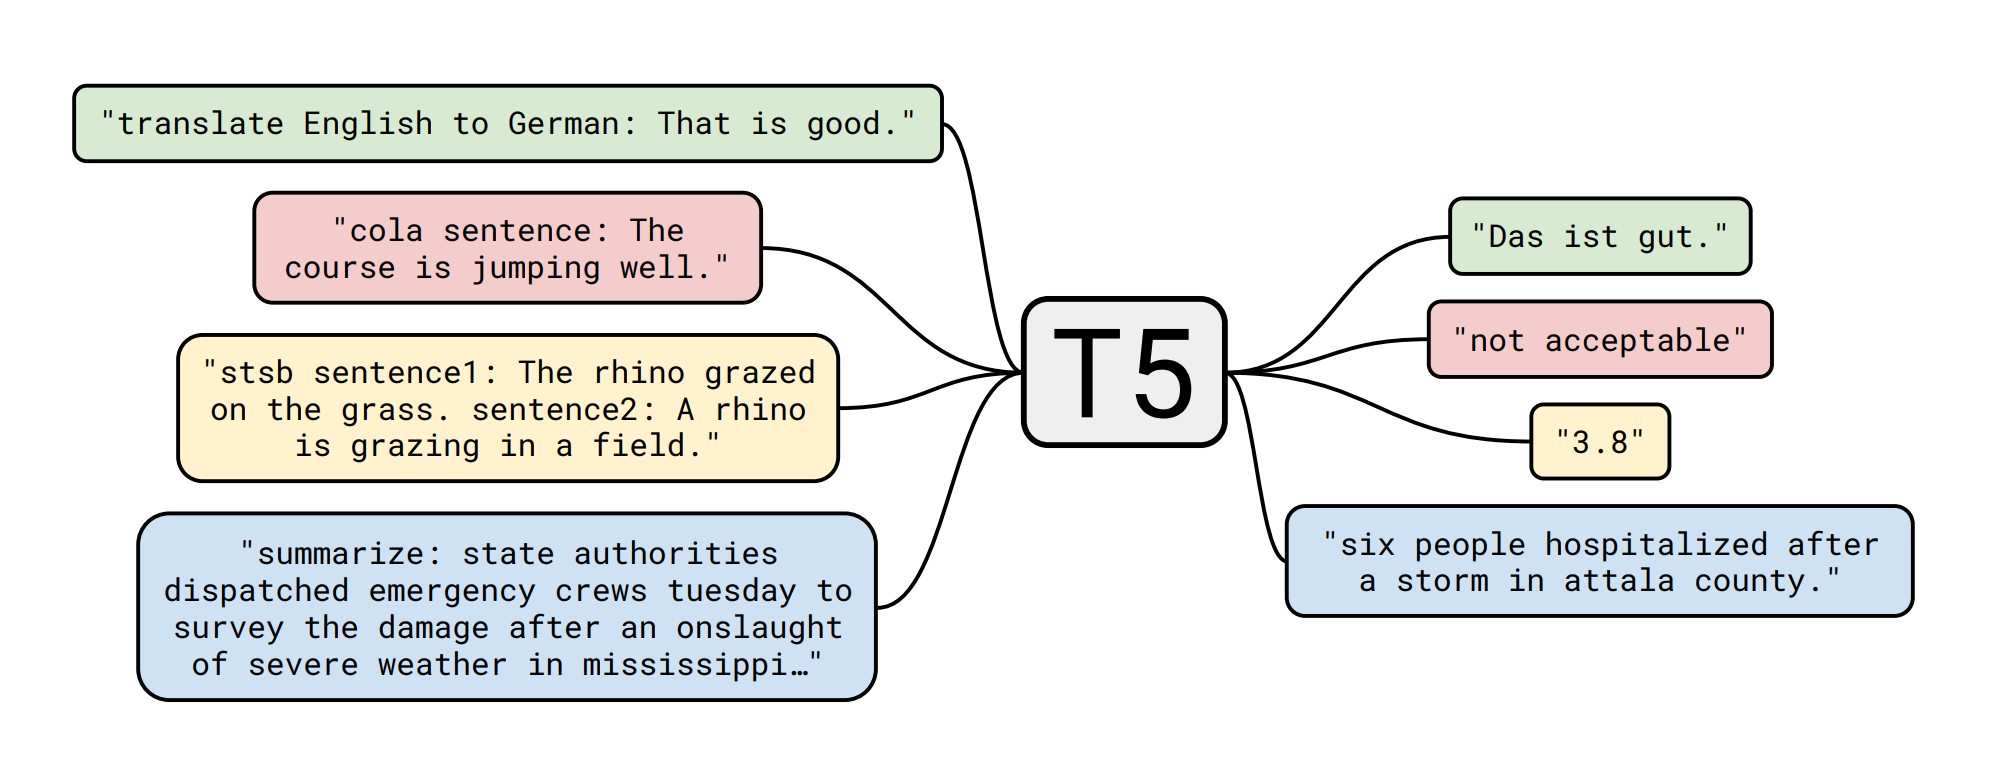



## The dataset
## [WikiSQL](https://github.com/salesforce/WikiSQL)
### A large crowd-sourced dataset for developing natural language interfaces for relational databases. WikiSQL is the dataset released along with Seq2SQL: Generating Structured Queries from Natural Language using Reinforcement Learning.

## Training with 🤗 ecosystem

In [1]:
! nvidia-smi

Sun Apr  3 20:59:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install -q transformers datasets

## HF auth

In [3]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/token.
        (Deprecated, will be removed in v0.3.0) To login with username and password instead, interrupt with Ctrl+C.
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token


In [4]:
! git config --global credential.helper store

In [5]:
%%capture
! sudo apt-get install git-lfs

## Model and tokenizer

In [6]:
CKPT = 't5-small'
from transformers import AutoTokenizer, T5ForConditionalGeneration
tokenizer = AutoTokenizer.from_pretrained(CKPT)
model = T5ForConditionalGeneration.from_pretrained(CKPT)

## Dataset preparation

### Let's load the dataset

In [7]:
from datasets import load_dataset

train_data = load_dataset('wikisql', split='train+validation')
test_data = load_dataset('wikisql', split='test')

Using custom data configuration default
Reusing dataset wiki_sql (/root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d)
Using custom data configuration default
Reusing dataset wiki_sql (/root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d)


### Let's explore the dataset

In [8]:
train_data

Dataset({
    features: ['phase', 'question', 'table', 'sql'],
    num_rows: 64776
})

In [9]:
train_data[0]

{'phase': 1,
 'question': 'Tell me what the notes are for South Australia ',
 'sql': {'agg': 0,
  'conds': {'column_index': [3],
   'condition': ['SOUTH AUSTRALIA'],
   'operator_index': [0]},
  'human_readable': 'SELECT Notes FROM table WHERE Current slogan = SOUTH AUSTRALIA',
  'sel': 5},
 'table': {'caption': '',
  'header': ['State/territory',
   'Text/background colour',
   'Format',
   'Current slogan',
   'Current series',
   'Notes'],
  'id': '1-1000181-1',
  'name': 'table_1000181_1',
  'page_id': '',
  'page_title': '',
  'rows': [['Australian Capital Territory',
    'blue/white',
    'Yaa·nna',
    'ACT · CELEBRATION OF A CENTURY 2013',
    'YIL·00A',
    'Slogan screenprinted on plate'],
   ['New South Wales',
    'black/yellow',
    'aa·nn·aa',
    'NEW SOUTH WALES',
    'BX·99·HI',
    'No slogan on current series'],
   ['New South Wales',
    'black/white',
    'aaa·nna',
    'NSW',
    'CPX·12A',
    'Optional white slimline series'],
   ['Northern Territory',
    'ochr

### Let's format the dataset


In [10]:
def format_dataset(example):
 return {'input': 'translate to SQL: ' + example['question'], 'target': example['sql']['human_readable']}

In [11]:
train_data = train_data.map(format_dataset, remove_columns=train_data.column_names)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d/cache-f6eaa945d21cf0a1.arrow


In [12]:
test_data = test_data.map(format_dataset, remove_columns=test_data.column_names)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d/cache-e2cff5b3a1b5b6d3.arrow


In [13]:
train_data

Dataset({
    features: ['input', 'target'],
    num_rows: 64776
})

### Let's calculate the inputs and targets lengths

In [14]:
# map article and summary len to dict as well as if sample is longer than 512 tokens
def map_to_length(x):
  x["input_len"] = len(tokenizer(x["input"]).input_ids)
  x["input_longer_256"] = int(x["input_len"] > 256)
  x["input_longer_128"] = int(x["input_len"] > 128)
  x["input_longer_64"] = int(x["input_len"] > 64)
  x["out_len"] = len(tokenizer(x["target"]).input_ids)
  x["out_longer_256"] = int(x["out_len"] > 256)
  x["out_longer_128"] = int(x["out_len"] > 128)
  x["out_longer_64"] = int(x["out_len"] > 64)
  return x

sample_size = 10000
data_stats = train_data.select(range(sample_size)).map(map_to_length, num_proc=4)

def compute_and_print_stats(x):
  if len(x["input_len"]) == sample_size:
    print(
        "Input Mean: {}, %-Input > 256:{},  %-Input > 128:{}, %-Input > 64:{} Output Mean:{}, %-Output > 256:{}, %-Output > 128:{}, %-Output > 64:{}".format(
            sum(x["input_len"]) / sample_size,
            sum(x["input_longer_256"]) / sample_size,
            sum(x["input_longer_128"]) / sample_size,
            sum(x["input_longer_64"]) / sample_size,   
            sum(x["out_len"]) / sample_size,
            sum(x["out_longer_256"]) / sample_size,
            sum(x["out_longer_128"]) / sample_size,
            sum(x["out_longer_64"]) / sample_size,
        )
    )

output = data_stats.map(
  compute_and_print_stats, 
  batched=True,
  batch_size=-1,
)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d/cache-1863bb36f979efb5.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d/cache-5950cb3095aabe7d.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d/cache-91b402e4a19939bd.arrow


Loading cached processed dataset at /root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d/cache-83eac86c86834f97.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Input Mean: 19.8508, %-Input > 256:0.0,  %-Input > 128:0.0, %-Input > 64:0.0002 Output Mean:20.0403, %-Output > 256:0.0, %-Output > 128:0.0002, %-Output > 64:0.0005


As we can see input and output mean are around 20 tokens. So we should not use less than 20 token in both econder and decoder to keep all the info there. For this example we will use 64, but we could use 32.

### Let's tokenize our data

In [15]:
# tokenize the examples
def convert_to_features(example_batch):
    input_encodings = tokenizer.batch_encode_plus(example_batch['input'], pad_to_max_length=True, max_length=64)
    target_encodings = tokenizer.batch_encode_plus(example_batch['target'], pad_to_max_length=True, max_length=64)

    encodings = {
        'input_ids': input_encodings['input_ids'], 
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids'],
        'decoder_attention_mask': target_encodings['attention_mask']
    }

    return encodings

In [16]:
train_data = train_data.map(convert_to_features, batched=True, remove_columns=train_data.column_names)
test_data = test_data.map(convert_to_features, batched=True, emove_columns=test_data.column_names)

columns = ['input_ids', 'attention_mask', 'labels', 'decoder_attention_mask']

train_data.set_format(type='torch', columns=columns)
test_data.set_format(type='torch', columns=columns)

Loading cached processed dataset at /root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d/cache-650d53a36abe5b77.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d/cache-74e255cfb147a24f.arrow


In [17]:
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments

### Set the training arguments

In [20]:
# set training arguments - Feel free to adapt it
training_args = Seq2SeqTrainingArguments(
    output_dir="/content/t5-small-finetuned-wikisql",
    per_device_train_batch_size=16,
    num_train_epochs=5,
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=500,
    save_strategy="epoch",
    #save_steps=1000,
    #eval_steps=1000,
    overwrite_output_dir=True,
    save_total_limit=3,
    load_best_model_at_end=True,
    push_to_hub=True
    #fp16=True, 
)

### Let's define a metric to track our training progress

In [21]:
! pip install -q rouge_score

In [22]:
from datasets import load_metric
rouge = load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }

### Let's create a `Trainer` instance

In [23]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data,
)

Let's run a sanity check

In [23]:
trainer.evaluate()

The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input, target. If input, target are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16


{'eval_loss': 8.005945205688477,
 'eval_rouge2_fmeasure': 0.0778,
 'eval_rouge2_precision': 0.0785,
 'eval_rouge2_recall': 0.0796,
 'eval_runtime': 232.7062,
 'eval_samples_per_second': 68.232,
 'eval_steps_per_second': 4.267}

Track the training in real time using `tensorboard`

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/t5-small-finetuned-wikisql/runs

In [26]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input, target. If input, target are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 64776
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 20245


Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
1,0.191800,0.156427,0.792600,0.702900,0.738100
2,0.165500,0.138190,0.809200,0.717100,0.753400
3,0.152500,0.129753,0.815400,0.723700,0.759700
4,0.144300,0.126204,0.816300,0.724100,0.760300
5,0.141400,0.124436,0.817500,0.725800,0.761800


The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input, target. If input, target are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16
Saving model checkpoint to /content/t5-small-finetuned-wikisql/checkpoint-4049
Configuration saved in /content/t5-small-finetuned-wikisql/checkpoint-4049/config.json
Model weights saved in /content/t5-small-finetuned-wikisql/checkpoint-4049/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input, target. If input, target are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 15878
  Batch size = 16
Saving model checkpoint to /content/t5-small-finetuned-

TrainOutput(global_step=20245, training_loss=0.17887339593157647, metrics={'train_runtime': 2831.3401, 'train_samples_per_second': 114.391, 'train_steps_per_second': 7.15, 'total_flos': 5479312832593920.0, 'train_loss': 0.17887339593157647, 'epoch': 5.0})

In [48]:
trainer.save_model()

Saving model checkpoint to /content/t5-small-finetuned-wikisql
Configuration saved in /content/t5-small-finetuned-wikisql/config.json
Model weights saved in /content/t5-small-finetuned-wikisql/pytorch_model.bin


In [49]:
tokenizer.save_pretrained('/content/t5-small-finetuned-wikisql')

tokenizer config file saved in /content/t5-small-finetuned-wikisql/tokenizer_config.json
Special tokens file saved in /content/t5-small-finetuned-wikisql/special_tokens_map.json


('/content/t5-small-finetuned-wikisql/tokenizer_config.json',
 '/content/t5-small-finetuned-wikisql/special_tokens_map.json',
 '/content/t5-small-finetuned-wikisql/tokenizer.json')

In [28]:
trainer.create_model_card()

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Sequence-to-sequence Language Modeling', 'type': 'text2text-generation'}, 'dataset': {'name': 'wiki_sql', 'type': 'wiki_sql', 'args': 'default'}}


In [ ]:
trainer.push_to_hub()

### Test the model

In [ ]:
CKPT = '/content/t5-small-finetuned-wikisql'
from transformers import AutoTokenizer, T5ForConditionalGeneration
tokenizer = AutoTokenizer.from_pretrained(CKPT)
model = T5ForConditionalGeneration.from_pretrained(CKPT)

In [51]:
test_data = load_dataset('wikisql', split='test')

Using custom data configuration default
Reusing dataset wiki_sql (/root/.cache/huggingface/datasets/wiki_sql/default/0.1.0/7037bfe6a42b1ca2b6ac3ccacba5253b1825d31379e9cc626fc79a620977252d)


In [66]:
def translate_to_sql(text):
    inputs = tokenizer(text, padding='longest', max_length=64, return_tensors='pt')
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    output = model.generate(input_ids, attention_mask=attention_mask, max_length=64)

    return tokenizer.decode(output[0], skip_special_tokens=True)

In [67]:
for i in range(0,100,10):
  print('translate to SQL: ' + test_data[i]['question'])
  print('Predict. :' + translate_to_sql('translate to SQL: ' + test_data[i]['question']))
  print('Expected: ' + test_data[i]['sql']['human_readable'])
  print('=================================\n')

translate to SQL: What is terrence ross' nationality
Predict. :SELECT Nationality FROM table WHERE Player = Terrence Ross
Expected: SELECT Nationality FROM table WHERE Player = Terrence Ross

translate to SQL: How many different nationalities do the players of New Jersey Devils come from?
Predict. :SELECT COUNT Nationality FROM table WHERE Team = New Jersey Devils
Expected: SELECT COUNT Nationality FROM table WHERE NHL team = New Jersey Devils

translate to SQL: If you are a pilot officer in the commonwealth then what will you called as in the US air force?
Predict. :SELECT US air force FROM table WHERE Position = pilot officer AND Country = commonwealth
Expected: SELECT US Air Force equivalent FROM table WHERE Commonwealth equivalent = Pilot Officer

translate to SQL: what is the total number of total w–l where doubles w–l is 11–11
Predict. :SELECT COUNT Total W–L FROM table WHERE Doubles W–L = 11–11
Expected: SELECT COUNT Total W–L FROM table WHERE Doubles W–L = 11–11

translate to S

Custom example

In [70]:
text = "translate to SQL: How many model with BERT architecture are in the HuggingFace Hub?"
translate_to_sql(text)

'SELECT COUNT Model FROM table WHERE Architecture = BERT AND Hub = HuggingFace'

## Acknowledgments

- [Narrativa](https://narrativa.com)
- [HuggingFace](https://huggingface.co/mrm8488)
- [QBLOCKS](https://www.qblocks.cloud/)